In [1]:
import pickle as pkl
import numpy as np
import healpy as hp
import pylab as plt
import camb
from scipy import stats,optimize
import sys
import os
#sys.path.append('../gaia-quasars-lss/code')
#from lensing_qso_cross_utils import get_custom_binning,define_binning
import pymaster as nmt
import astropy.constants as const
from scipy import interpolate
from bins import Bins
import matplotlib.pyplot as plt

### Define $\ell$ bins

In [2]:
nside = 16
nside_hr = 256
dell = 2 #binning
lmin = 2 # doesn't matter as code forces lmin=2 and cls assum l_0=l_1=0.
lmax = 3 * nside - 1
lmax_hr = 3 * nside_hr -1
def get_binning_custom():
    lmins = np.arange(2,40,2)
    lmins = np.append(lmins,np.arange(40,60,5))
    lmins = np.append(lmins,np.arange(60,767,30))

    lmaxs = np.arange(4,42,2)
    lmaxs = np.append(lmaxs,np.arange(45,65,5))
    lmaxs = np.append(lmaxs,np.arange(90,767,30))
    lmaxs = np.append(lmaxs,767)
    return lmins,lmaxs

lmins,lmaxs = get_binning_custom()
bins_nmt= nmt.NmtBin.from_edges(lmins, lmaxs, is_Dell=False)
binning = bins_nmt

In [3]:
ells = binning.get_effective_ells()
#np.savez("data/namaster_ells.npz", ells)

In [4]:
binning.lmax

766

### load n(z) and bias models

In [5]:
#dndz = np.loadtxt('dndz_zerr_20230406.dat',unpack=True)
nofz = np.load("data/mynz.npy")
dndz = np.zeros((2,1000))
dndz[0,:] = nofz["z"]
dndz[1,:] = nofz["nz"]
z_W = np.array(dndz[0])
W = np.array(dndz[1])

bz_qso_th_positive = np.array([[0.50,1.32 ,0.17 ],[1.13 ,2.31 ,0.22],[1.68,2.96 ,0.26 ],[2.18,4.69 ,0.70 ],
                               [3.17,7.76 ,1.44 ],[3.84,12.96,2.09 ]])
bz_qso_th = np.array([[0.50,1.32,0.17 ],[1.13 ,2.20,0.23 ],[1.68 ,2.49,0.27 ],[2.18 ,3.29,0.79 ],
                      [3.17,7.10,1.48],[3.84,9.85,2.27]])

#bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value=(0.,0.),bounds_error=False)
bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value='extrapolate',bounds_error=False)



# Laurent+2017 notice last bin is the effective one https://arxiv.org/pdf/1705.04718.pdf
bz_qso_laurent = np.array([[1.06,1.75, 0.08],[1.35,2.06, 0.08],[1.65,2.57, 0.09],
                           [1.99,3.03, 0.11],[1.55,2.43, 0.05]])

bz_laurent = interpolate.interp1d(bz_qso_laurent[:,0],bz_qso_laurent[:,1],fill_value='extrapolate',bounds_error=False)


# Photometric model in agreement with Sherwin+2012 and Leisted+2015
def bz_sdss_photo(z):
    return 1+((1+z)/2.5)**5

def bz_desi(z):
    return 0.278*((1+z)**2-6.565)+2.393

b_z = 0.278*((1+z_W)**2-6.565)+2.393

In [6]:
bz_sdss

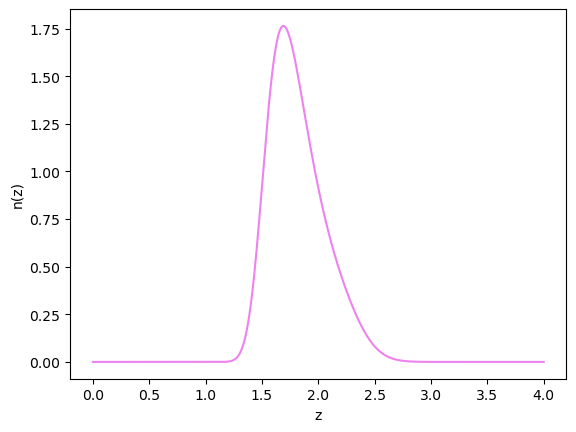

In [7]:
plt.plot(z_W, W, color="violet")
plt.xlabel("z")
plt.ylabel("n(z)");

Text(0.5, 1.0, 'Biases')

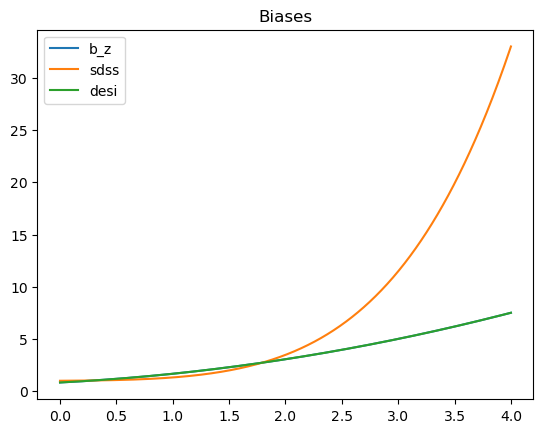

In [8]:
plt.plot(z_W, b_z, label="b_z")
plt.plot(z_W, bz_sdss_photo(z_W), label="sdss")
plt.plot(z_W, bz_desi(z_W), label="desi")
plt.legend()
plt.title("Biases")

## Set up CAMB

In [9]:
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

In [10]:
# Cosmology definition - adjusted to match blast one
h0 = 0.6727 #0.67
Ob = 0.0492 #071330589849
Odm= 0.2664 #19039780521262
As = np.e**3.047/1e10
ns = 0.9645#65

In [11]:
#CHANGED L_MIN_LIMBER TO 200, TO MATCH WITH BLAST
def init_pars(lmin_limber=200,do_magnification_bias=0.,do_cmb = True, do_transfer=True):

    pars = camb.CAMBparams()
    lmax = 1000 #3*256-1
    print("lmin_limber: ", lmin_limber)
    pars.set_cosmology(H0=h0*100, ombh2=Ob*h0**2, omch2=Odm*h0**2, mnu=0, tau=0.0561)
    pars = camb.set_params(H0=h0*100, ombh2=Ob*h0**2, omch2=Odm*h0**2, mnu=0,tau=0.0561,halofit_version='takahashi')
    #As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = do_cmb
    pars.Want_transfer = do_transfer
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #pars.NonLinear = model.NonLinear_none

    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = lmin_limber
    if do_magnification_bias > 0:
        pars.SourceTerms.counts_lensing = False  # force to avoid confusion
    else:
        pars.SourceTerms.counts_lensing = False

    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = False #weird problems at times
    pars.SourceTerms.counts_radial   = False # negligible at l<10
    pars.SourceTerms.counts_timedelay = False # negligible
    pars.SourceTerms.counts_ISW = False #negligible
    pars.SourceTerms.counts_velocity = False #negligible
    pars.SourceTerms.counts_potential = False #negligible
    pars.SourceTerms.counts_evolve = False # not sure what this is
    
    pars.Accuracy.LensingBoost = 2.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 2.0
    pars.Accuracy.SourcekAccuracyBoost=2.
    return pars

In [12]:
nz = 150 #number of steps to use for the radial/redshift integration
kmax = 1000  #kmax to use

#First set up parameters as usual
pars = init_pars(do_cmb=True)

results_bg = camb.get_background(pars)
chistar = results_bg.conformal_time(0)- results_bg.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs = results_bg.redshift_at_comoving_radial_distance(chis)
pars.set_matter_power(redshifts=zs, kmax=kmax)
results = camb.get_results(pars)
trans = results.get_matter_transfer_data()

#k_trans = get kh - the values of k/h at which they are calculated and convert to k
kh = trans.transfer_data[0,:,0] # note earliest redshift first
k = kh*results.Params.h
delta = trans.transfer_data[model.Transfer_tot-1,:,-1]
delta = np.interp(kh/pars.h,kh,delta)

Tk = interpolate.interp1d(k,delta/delta[0],fill_value='extrapolate',bounds_error=False)
Dz = interpolate.interp1d(zs,results.get_sigma8()[::-1]/results.get_sigma8_0(),fill_value='extrapolate',bounds_error=False)

lmin_limber:  200
Note: redshifts have been re-sorted (earliest first)


In [13]:
PK1 = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax, zmax=zs[-1])

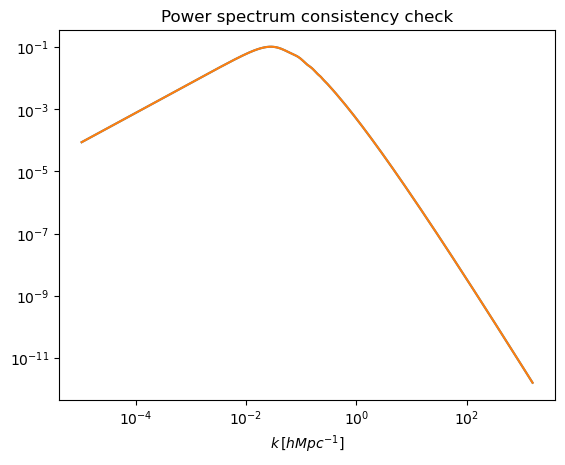

In [14]:
#k = kh*results.Params.h
#transfer = trans.transfer_data[model.Transfer_tot-1,:,0]
#primordial_PK = results.Params.scalar_power(k)
#matter_power = primordial_PK*transfer**2*k**4 / (k**3/(2*np.pi**2))

#compare with CAMB's explicit output for the matter power spectrum
k2,zs,PK = results.get_linear_matter_power_spectrum(hubble_units=False)
kh_nonlin, _, PK_nl = results.get_nonlinear_matter_power_spectrum(hubble_units=False)

#plt.loglog(k2,matter_power)
plt.loglog(kh, PK[-1,:])
plt.loglog(kh_nonlin, PK_nl[-1,:])
plt.title("Power spectrum consistency check")
plt.xlabel(r'$k\, [h Mpc^{-1}]$');

In [15]:
PK.shape

(150, 732)

In [16]:
def Om(z):
    #Om = (pars.omnuh2+pars.omch2+pars.ombh2)/pars.h**2
    return results.get_Omega('nu',z)+results.get_Omega('baryon',z)+results.get_Omega('cdm',z)

delta_c = 1.686
c = const.c.to('km/s').value

def bz_constant(z):
    if type(z) == np.ndarray:
        b_g_z=np.ones_like(z)
    else:
        b_g_z = 1.
    return b_g_z

def b_g(z,bz_model=bz_sdss):
    b_g_z = bz_model(z)
    if type(z) == np.ndarray:
        b_g_z[b_g_z<1.]=1.
    else:
        if b_g_z<1:
            b_g_z=1.
    return b_g_z

def b_phi(z,bz_model=bz_desi,bg_model_rescaling=1,bphi_shift=1):
    return delta_c*(b_g(z,bz_model)*bg_model_rescaling - bphi_shift)

def db_g(z,k,fNL=1.,z_pivot=0,bz_model=bz_desi,bg_model_rescaling=1):
    # results.h_of_z gives H0(z)/c 
    return fNL*3*Om(z_pivot)*(results.h_of_z(z_pivot))**2*b_phi(z,bz_model,bg_model_rescaling=bg_model_rescaling)/(Dz(z)*Tk(k)*k**2)

def b_h(z,k,fNL=1,z_pivot=0,bz_model=bz_desi,bg_model_rescaling=1):
    b_h = bg_model_rescaling*b_g(z,bz_model)+db_g(z,k,fNL,z_pivot,bz_model,bg_model_rescaling)
    return b_h

In [17]:
def get_theory_cl(bias_func,dndz,fNL_th=0.,bz_model=bz_desi,bg_model_rescaling=1,do_magnification=0.39,lmax_th = binning.lmax,lmin_limber=200):
    
    pars_nolimber = init_pars(lmin_limber=lmin_limber,do_magnification_bias=do_magnification,do_cmb=False,do_transfer=False) 
    
    
    zs_p = np.array(dndz[0]) #zs[zs<=dndz[0][-1]]
    ks = np.logspace(-6, 3, len(zs_p))
    bias_kz = np.ones((len(ks), len(zs_p)))
    
    for _i,z_i in enumerate(zs_p):
        bias_kz[:,_i] = bias_func(z_i,ks,fNL=fNL_th,z_pivot=0,bz_model=bz_model,bg_model_rescaling=bg_model_rescaling)
        
    W = np.array(dndz[1])
    
    if fNL_th==0:
        pars_nolimber.SourceWindows = [SplinedSourceWindow(bias=1, z=zs_p, W=W,source_type='counts',dlog10Ndm = 0), \
                                       SplinedSourceWindow(bias=1, z=zs_p, W=W,source_type='counts',dlog10Ndm = 0)]
    else:
        pars_nolimber.SourceWindows = [SplinedSourceWindow(k_bias=ks, bias_kz=bias_kz, z=zs_p, W=W,source_type='counts',dlog10Ndm = 0)]
        
    results_nolimber = camb.get_results(pars_nolimber)
    cls_nolimber = results_nolimber.get_source_cls_dict(raw_cl=True)        

    l_camb = np.arange(len(cls_nolimber["W1xW1"]))
    p2k= l_camb*(l_camb+1)/2    
    
    cl_gg_th = cls_nolimber['W1xW1']
    cl_kg_th = cls_nolimber['W1xP']*p2k
    cl_kk_th = cls_nolimber['PxP']*p2k**2
    if fNL_th==0:
        cl_gg_th_nok = cls_nolimber['W2xW2']
        cl_kg_th_nok = cls_nolimber['W2xP']*p2k
        return l_camb[:lmax_th+1],cl_kg_th[:lmax_th+1], cl_gg_th[:lmax_th+1],cl_kk_th[:lmax_th+1],cl_gg_th_nok[:lmax_th+1],cl_kg_th_nok[:lmax_th+1]
    else:
        return l_camb[:lmax_th+1],cl_kg_th[:lmax_th+1], cl_gg_th[:lmax_th+1],cl_kk_th[:lmax_th+1]

In [18]:
# defines same z range as done for later in CCL
zint = np.linspace(0,5,1024)

fNL=0.
cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000)
cls_th_lim = get_theory_cl(b_h,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000,lmin_limber=1)

lmin_limber:  200
lmin_limber:  1


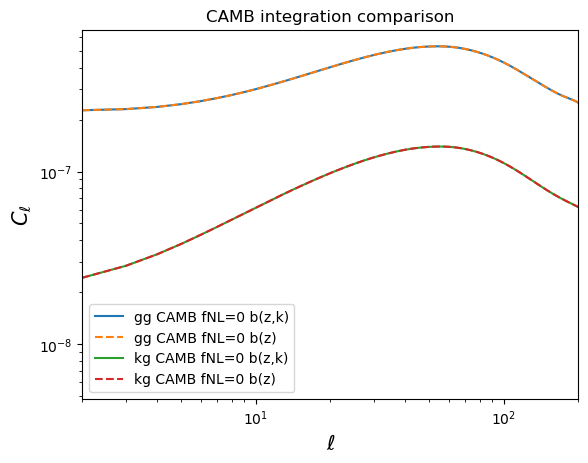

In [19]:
plt.loglog(cls_th[0][2:],cls_th_lim[2][2:],label='gg CAMB fNL=0 b(z,k)')
plt.loglog(cls_th[0][2:],cls_th_lim[4][2:],ls='--',label='gg CAMB fNL=0 b(z)')

plt.loglog(cls_th[0][2:],cls_th_lim[1][2:],label='kg CAMB fNL=0 b(z,k)')
plt.loglog(cls_th[0][2:],cls_th_lim[5][2:],ls='--',label='kg CAMB fNL=0 b(z)')
plt.ylabel("$C_\\ell$",size=15)
plt.xlabel('$\\ell$',size=15)
plt.legend()
plt.xlim(2,200)
plt.title("CAMB integration comparison")
plt.show()

In [20]:
## Do it by hand step by step to really figure out 

In [21]:
pars_nolimber = init_pars(lmin_limber = 200, do_magnification_bias = 0, do_cmb = True, do_transfer = False) 

lmin_limber:  200


In [22]:
zint = np.linspace(0,5,1024)
dndz = [zint,np.interp(zint,dndz[0],dndz[1])]

In [23]:
zs_p = np.array(dndz[0])
ks = np.logspace(np.log10(1e-4), np.log10(15), len(zs_p))
bias_kz = np.ones((len(ks), len(zs_p)))
    
for _i,z_i in enumerate(zs_p):
        bias_kz[:,_i] = 1.

W = np.array(dndz[1])

In [24]:
pars_nolimber.SourceWindows = [SplinedSourceWindow(bias=1, z=zs_p, W=W, source_type='counts', dlog10Ndm = 0),
SplinedSourceWindow(bias=1, z=zs_p, W=W, source_type='lensing', dlog10Ndm = 0)]

In [25]:
results_nolimber = camb.get_results(pars_nolimber)

In [26]:
cls_nolimber = results_nolimber.get_source_cls_dict(raw_cl=True)

In [27]:
cls_nolimber

{'PxP': array([0.00000000e+00, 0.00000000e+00, 8.85385978e-09, ...,
        2.04262315e-20, 2.03260281e-20, 2.02263375e-20]),
 'PxW1': array([0.00000000e+00, 0.00000000e+00, 8.61096620e-09, ...,
        7.21172027e-15, 7.18860717e-15, 7.16558201e-15]),
 'PxW2': array([0.00000000e+00, 0.00000000e+00, 1.88890402e-08, ...,
        2.25636028e-15, 2.24994912e-15, 2.24356116e-15]),
 'W1xP': array([0.00000000e+00, 0.00000000e+00, 8.61096620e-09, ...,
        7.21172027e-15, 7.18860717e-15, 7.16558201e-15]),
 'W1xW1': array([0.00000000e+00, 0.00000000e+00, 1.99224561e-07, ...,
        1.69556417e-08, 1.69305789e-08, 1.69055771e-08]),
 'W1xW2': array([0.00000000e+00, 0.00000000e+00, 7.19503732e-09, ...,
        3.13228156e-10, 3.12779099e-10, 3.12331131e-10]),
 'W2xP': array([0.00000000e+00, 0.00000000e+00, 1.88890402e-08, ...,
        2.25636028e-15, 2.24994912e-15, 2.24356116e-15]),
 'W2xW1': array([0.00000000e+00, 0.00000000e+00, 7.19503732e-09, ...,
        3.13228156e-10, 3.12779099e-10, 

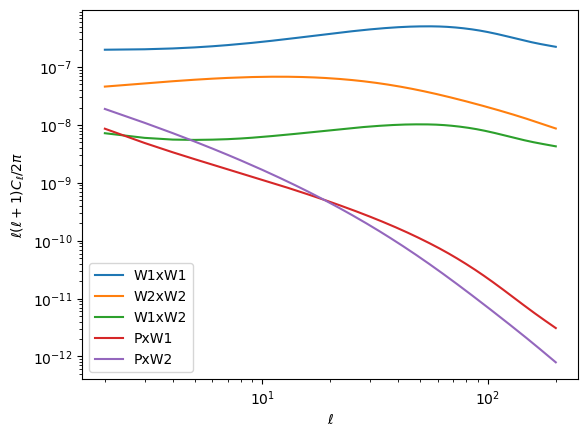

In [28]:
lmax_plot = 200
ls =  np.arange(2, lmax_plot+1)
for spectrum in ['W1xW1','W2xW2','W1xW2',"PxW1", "PxW2"]:
    plt.loglog(ls, cls_nolimber[spectrum][2:lmax_plot+1], label=spectrum)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();

In [29]:
ell_list = np.load("data/ell_list.npy")
blast_gg = np.load("blast_cls/D_gg.npy")
blast_ss = np.load("blast_cls/D_ss.npy")
blast_gs = np.load("blast_cls/D_gs.npy")
blast_gcmbl = np.load("blast_cls/D_gcmbl.npy")
blast_scmbl = np.load("blast_cls/D_scmbl.npy")

In [30]:
camb_ells = np.arange(1, cls_nolimber["W1xW1"].shape[0])[2:lmax_plot+1]

Text(0.5, 1.0, 'galaxy-galaxy')

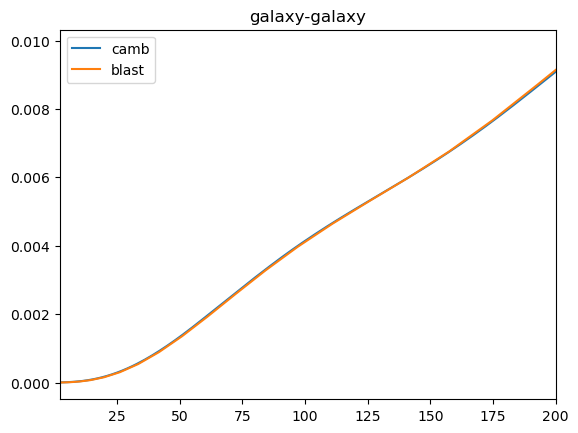

In [31]:
plt.plot(ls, camb_ells*(camb_ells+1)*cls_nolimber["W1xW1"][2:lmax_plot+1], label = "camb")
plt.plot(ell_list, blast_gg, label= "blast")
plt.legend()
plt.xlim((2,200))
plt.title("galaxy-galaxy")

Text(0.5, 1.0, 'shear-shear')

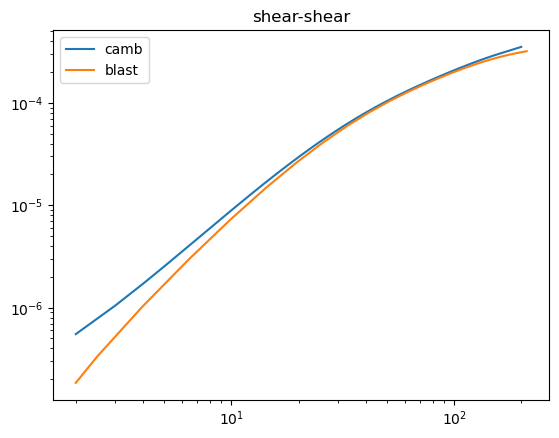

In [32]:
plt.loglog(ls, camb_ells*(camb_ells+1)*cls_nolimber["W2xW2"][2:lmax_plot+1], label ="camb")
plt.loglog(ell_list, blast_ss, label ="blast")
plt.legend()
plt.title("shear-shear")

Text(0.5, 1.0, 'galaxy-galaxy lensing')

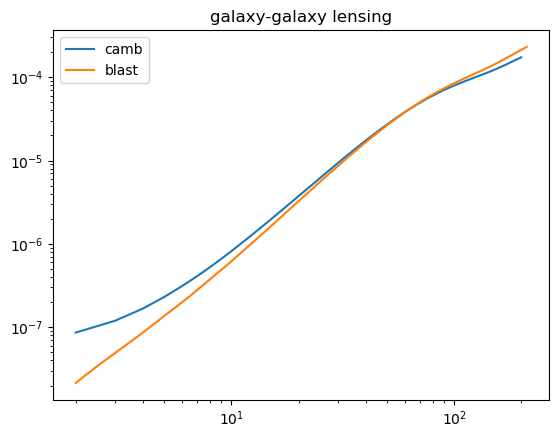

In [33]:
plt.loglog(ls, camb_ells*(camb_ells+1)*cls_nolimber["W1xW2"][2:lmax_plot+1], label = "camb")
plt.loglog(ell_list, blast_gs, label = "blast")
plt.legend()
plt.title("galaxy-galaxy lensing")

Text(0.5, 1.0, 'galaxy - cmb lensing')

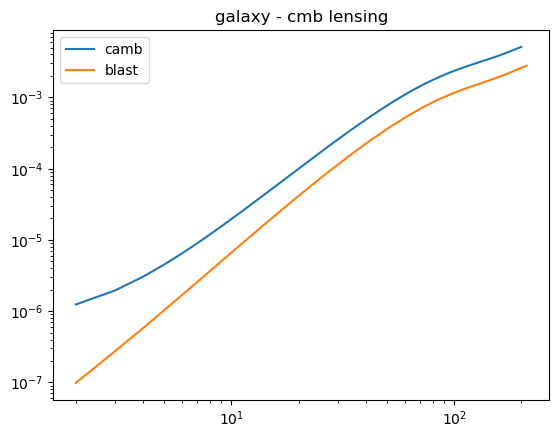

In [34]:
plt.loglog(ls, (camb_ells*(camb_ells+1))**(2)*cls_nolimber["PxW1"][2:lmax_plot+1]/2, label="camb")
plt.loglog(ell_list, blast_gcmbl, label="blast")
plt.legend()
plt.title("galaxy - cmb lensing")

Text(0.5, 1.0, 'shear - cmb lensing')

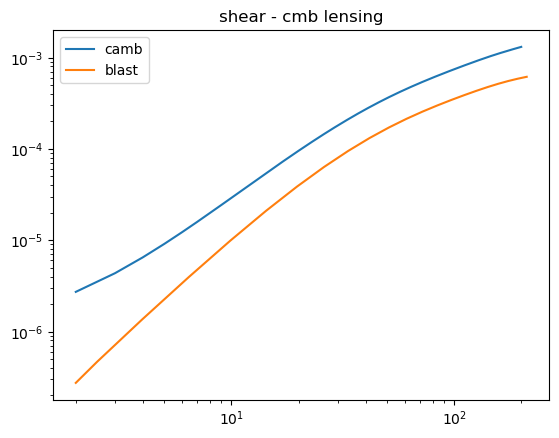

In [35]:
plt.loglog(ls, (camb_ells*(camb_ells+1))**(2)*cls_nolimber["PxW2"][2:lmax_plot+1]/2, label="camb")
plt.loglog(ell_list, blast_scmbl, label="blast")
plt.legend()
plt.title("shear - cmb lensing")

# Extracting the power spectrum for Blast

In [36]:
results= camb.get_background(pars_nolimber)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

In [37]:
PK = camb.get_matter_power_interpolator(pars_nolimber, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=20, zmax=zs[-1])

In [38]:
PK_nl = camb.get_matter_power_interpolator(pars_nolimber, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=20, zmax=zs[-1])

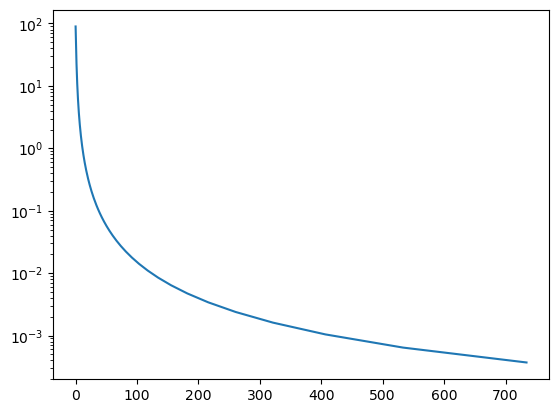

In [39]:
plt.plot(zs, PK.P(zs, 1))
plt.yscale("log")

In [40]:
k_cheb = np.load("data/k_cheb.npy")
z_cheb = np.load("data/z_cheb.npy")

In [41]:
k_cheb.shape

(120,)

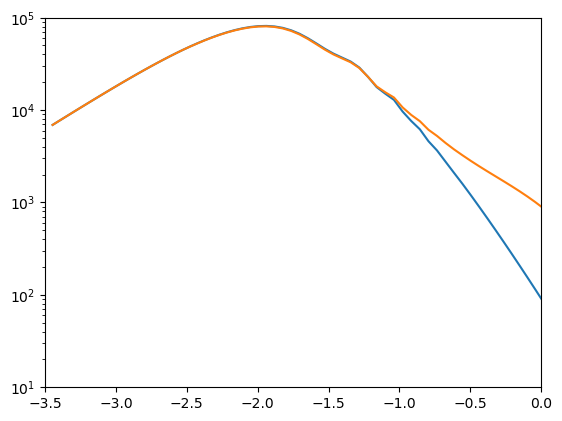

In [42]:
plt.plot(k_cheb, PK.P(0,10 ** k_cheb))
plt.plot(k_cheb, PK_nl.P(0,10 ** k_cheb))
plt.xlim(-3.5, 0)
plt.ylim(10, 1e5)
plt.yscale("log")

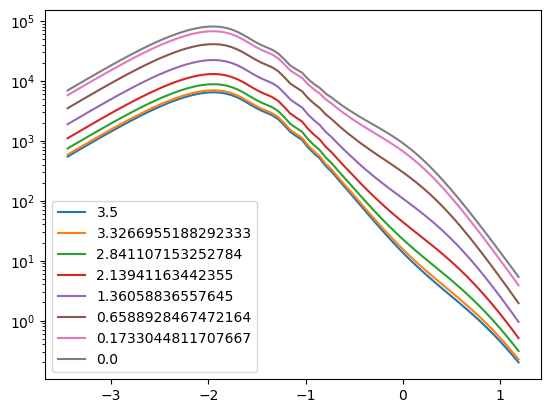

In [43]:
for z in z_cheb:
    #plt.plot(k_cheb, PK.P(z,10 ** k_cheb), label = f"{z}", color="r")
    plt.plot(k_cheb, PK_nl.P(z,10 ** k_cheb), label = f"{z}")
    plt.yscale("log")
plt.legend()

In [44]:
pk_to_interpolate = np.zeros((len(z_cheb), len(k_cheb)))
pk_nl_to_interpolate = np.zeros((50, 200))
pk_lin_to_interpolate = np.zeros((50, 200))

In [45]:
z_nl = np.linspace(0, 3.5, 50)
k_nl = np.logspace(np.min(k_cheb), np.max(k_cheb), 200)

In [46]:
for i, z in enumerate(z_cheb):
    pk_to_interpolate[i,:] = PK.P(z,10 ** k_cheb)

In [47]:
for i, z in enumerate(z_nl):
    pk_lin_to_interpolate[i,:] = PK.P(z, k_nl)

In [48]:
for i, z in enumerate(z_nl):
    pk_nl_to_interpolate[i,:] = PK_nl.P(z, k_nl)

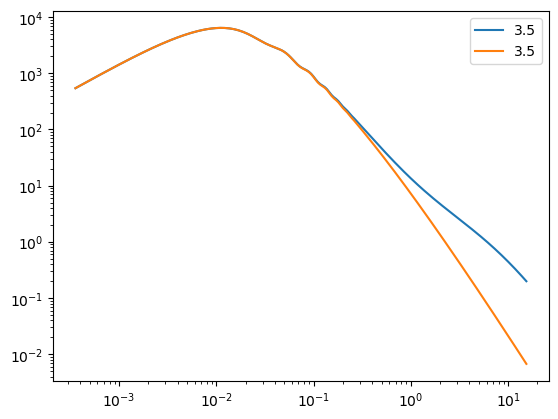

In [49]:
#plt.plot(10**k_cheb, pk_to_interpolate[0,:], label = f"{z_cheb[0]}")
plt.plot(k_nl, pk_nl_to_interpolate[-1,:], label = f"{z_nl[-1]}")
plt.plot(k_nl, pk_lin_to_interpolate[-1,:], label = f"{z_nl[-1]}")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [50]:
np.savez("data/camb_pk.npz", pk_to_interpolate)

In [51]:
np.savez("data/camb_nl_pk.npz", pk_nl_to_interpolate)

In [52]:
np.savez("data/camb_lin_pk.npz", pk_lin_to_interpolate)

In [53]:
np.savez("data/k_nl.npz", k_nl)
np.savez("data/z_nl.npz", z_nl)